In [290]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio

import tensorly as tl
from cmtf import CMTF
from utils import replace_nan, match_score, normalize_vector
from visualization import plot_match_scores

concentrations = pd.read_table("../Acar_data/concentrations.txt", sep="\s+")
mat = sio.loadmat("../Acar_data/EEM_NMR_LCMS.mat")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data description

# Mixture concentrations

In [246]:
gt_concentrations = np.zeros_like(concentrations)
for idx in range(concentrations.shape[1]):
    gt_concentrations[:, idx] = normalize_vector(concentrations.iloc[:, idx])

print(concentrations.shape)
print((concentrations != 0).sum(axis=1).describe())

(28, 5)
count    28.000000
mean      3.321429
std       1.278123
min       1.000000
25%       3.000000
50%       4.000000
75%       4.000000
max       5.000000
dtype: float64


## Fluorescence Spectroscopy (Excitation Emission Matrix - EEM)

- 28 mixtures
- emission wavelength (mode 2)
- excitation wavelength (mode 3)

In [247]:
eem = mat["X"][0][0]["data"]
eem = replace_nan(eem, strategy="zero")
print(eem.shape)

(28, 251, 21)


## NMR spectra
- 28 mixtures
- chemical shifts (mode 2)
- gradient levels (mode 3)

In [248]:
nmr = mat["Y"][0][0]["data"]
nmr = replace_nan(nmr, strategy="zero")
print(nmr.shape)

(28, 13324, 8)


## LC-MS

Matrix n_mixtures x n_features

In [249]:
lcms = mat["Z"][0][0]["data"]

print(lcms.shape)

(28, 168)


# Tensor decomposition

## PARAFAC

### NMR spectra only

In [258]:
rank = 5
fac_nmr = tl.decomposition.non_negative_parafac(nmr, rank=rank)

In [259]:
fac_nmr = tl.cp_normalize(fac_nmr)

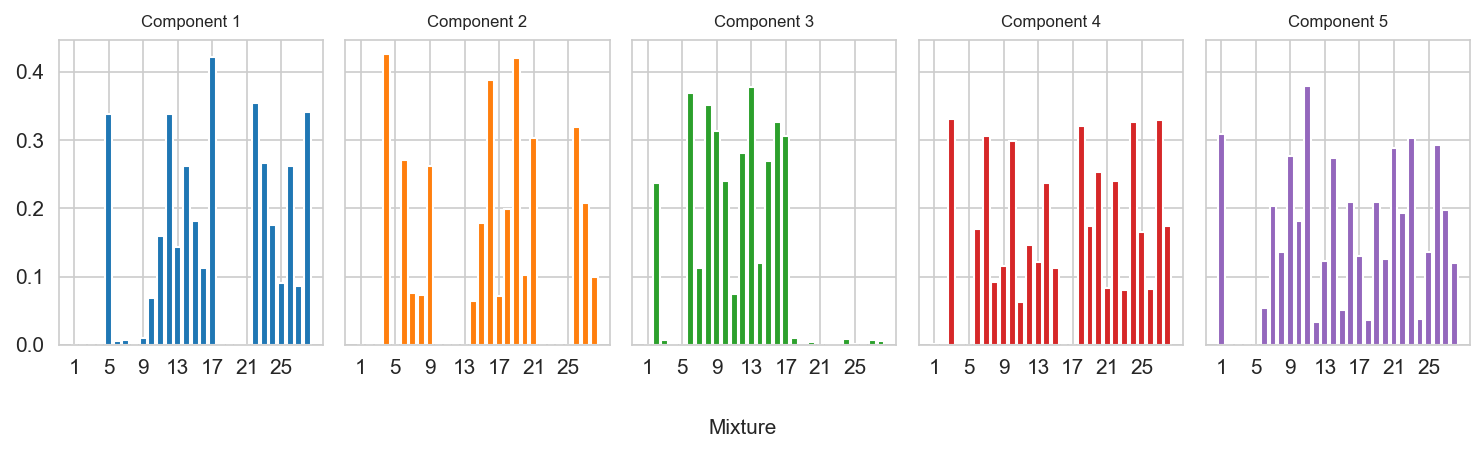

In [230]:
f, ax = plt.subplots(1, rank, figsize=(10, 3), sharex=True, sharey=True, dpi=150)

parafac_nmr_u1 = fac_nmr[1][0]
x_lig = np.arange(28)

for i in range(rank):
    ax[i].bar(x_lig, parafac_nmr_u1[:, i], label="Component 1", color=f"C{i}")
    ax[i].set_title(f"Component {i + 1}", fontsize=8)
ax[0].set_xticks(x_lig[::4], (x_lig + 1)[::4])
f.supxlabel("Mixture", fontsize=10)
f.tight_layout()
f.savefig("figures/parafac_nmr_spectra_cp_factors_per_mixture.pdf", dpi=300)
plt.show()

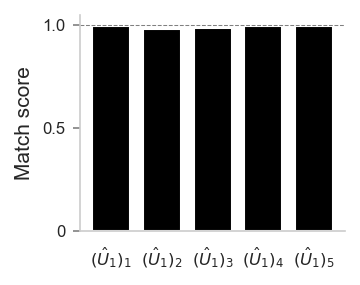

In [292]:
u1_scores_nmr, _, col_inds_nmr = match_score(gt_concentrations, parafac_nmr_u1, return_indices=True)

fig = plot_match_scores(
    u1_scores_nmr,
    x_ticks=np.arange(5),
    x_tick_labels=[rf"$(\hat U_1)_{idx}$" for idx in np.arange(1, 6)],
    colors="black",
    show=True,
)
fig.savefig("figures/parafac_nmr_match_score.pdf", dpi=300)

array([4, 2, 3, 1, 0])

### EEM tensor only

In [236]:
fac_eem = tl.decomposition.non_negative_parafac(eem, rank=rank, init="svd")
fac_eem = tl.cp_normalize(fac_eem)

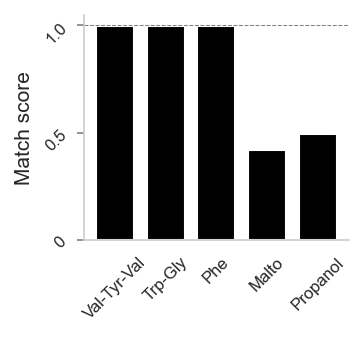

<Figure size 640x480 with 0 Axes>

In [302]:
parafac_eem_u1 = fac_eem[1][0]
u1_scores_eem, _, col_inds_eem = match_score(gt_concentrations, parafac_eem_u1, return_indices=True)

fig = plot_match_scores(
    u1_scores_eem,
    x_ticks=np.arange(5),
    x_tick_labels=concentrations.columns,
    colors="black",
    show=False,
)
plt.gca().tick_params(labelrotation=45)
plt.show()
plt.savefig("figures/parafac_eem_match_score.pdf", dpi=300)

### SVD on the matrix

In [257]:
u_lcms, s_lcms, v_lcms = np.linalg.svd(lcms, full_matrices=False)

print(v_lcms.shape)

estimations_concentrations = np.zeros_like(concentrations)
gt_concentrations = np.zeros_like(concentrations)
for idx in range(concentrations.shape[1]):
    estimations_concentrations[:, idx] = np.abs(normalize_vector(u_lcms[:, :5][:, idx]))
    gt_concentrations[:, idx] = normalize_vector(concentrations.iloc[:, idx])

(28, 168)


,Val-Tyr-Val,Trp-Gly,Phe,Malto,Propanol
1,-4.719944,0.000000,0.000000,0.000000,0.000000
2,0.000000,-4.658257,0.000000,0.000000,0.000000
3,0.000000,0.000000,-4.693214,0.000000,0.000000
4,0.000000,0.000000,0.000000,-4.603941,0.000000
5,0.000000,0.000000,0.000000,0.000000,-4.657003
6,-1.179986,-4.658257,-3.519911,-3.452956,0.000000
7,-3.539958,-1.164564,-4.693214,-1.150985,0.000000
8,-2.359972,-4.658257,-2.346607,-1.150985,0.000000
9,-4.719944,-3.493693,-2.346607,-3.452956,0.000000
10,-3.539958,-3.493693,-4.693214,0.000000,-1.164251


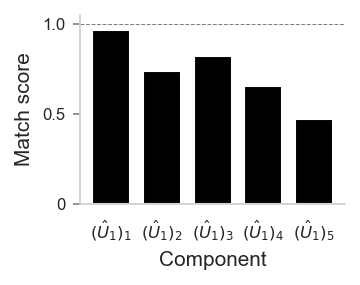

In [282]:
u1_scores_lcms, row_inds, col_inds_lcms = match_score(gt_concentrations, estimations_concentrations, return_indices=True)

fig = plot_match_scores(
    u1_scores_lcms,
    x_ticks=np.arange(5),
    x_tick_labels=[rf"$(\hat U_1)_{idx}$" for idx in np.arange(1, 6)],
    colors="black",
    show=True,
)
fig.savefig("figures/svd_lcms_match_score.pdf", dpi=300)

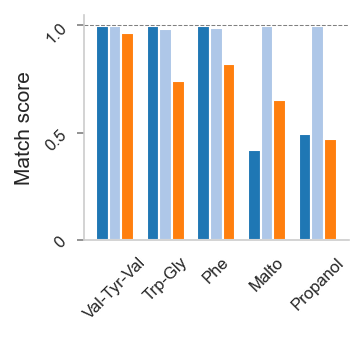

<Figure size 640x480 with 0 Axes>

In [304]:
fig = plot_match_scores(
    [u1_scores_eem, u1_scores_nmr, u1_scores_lcms],
    x_ticks=np.arange(5),
    x_tick_labels=concentrations.columns,
    show=False,
)
plt.gca().tick_params(labelrotation=45)
plt.show()
plt.savefig("figures/one_way_data_decomposition_comparison.pdf", dpi=300)

# CMTF

In [240]:
cmtf = CMTF(max_iter=10000)
out = cmtf.fit([eem], [lcms], rank=5)

2025-04-25 21:31:04,061 - Starting CMTF fit for rank = 5, lmbda = 1 with 1 tensors and 1 matrices
2025-04-25 21:31:04,220 - [Iter 100] delta U1 = 69.79532753
2025-04-25 21:31:04,388 - [Iter 200] delta U1 = 11.56435615
2025-04-25 21:31:04,662 - [Iter 300] delta U1 = 4.23506686
2025-04-25 21:31:04,939 - [Iter 400] delta U1 = 2.54892728
2025-04-25 21:31:05,137 - [Iter 500] delta U1 = 1.78007362
2025-04-25 21:31:05,581 - [Iter 600] delta U1 = 1.34332868
2025-04-25 21:31:05,727 - [Iter 700] delta U1 = 1.08464021
2025-04-25 21:31:05,889 - [Iter 800] delta U1 = 0.92743453
2025-04-25 21:31:06,020 - [Iter 900] delta U1 = 0.83298611
2025-04-25 21:31:06,180 - [Iter 1000] delta U1 = 0.78050073
2025-04-25 21:31:06,368 - [Iter 1100] delta U1 = 0.75750851
2025-04-25 21:31:06,530 - [Iter 1200] delta U1 = 0.75580041
2025-04-25 21:31:06,672 - [Iter 1300] delta U1 = 0.76966109
2025-04-25 21:31:06,802 - [Iter 1400] delta U1 = 0.79497133
2025-04-25 21:31:06,912 - [Iter 1500] delta U1 = 0.82865988
2025-04-2

In [241]:
estimations_concentrations = np.zeros_like(concentrations)
gt_concentrations = np.zeros_like(concentrations)
for idx in range(concentrations.shape[1]):
    estimations_concentrations[:, idx] = np.abs(normalize_vector(out[0][:, idx]))
    gt_concentrations[:, idx] = normalize_vector(concentrations.iloc[:, idx])

[0.99848455 0.99940758 0.9962823  0.54078869 0.55039821]
[2 0 1 3 4]
[0 1 2 3 4]


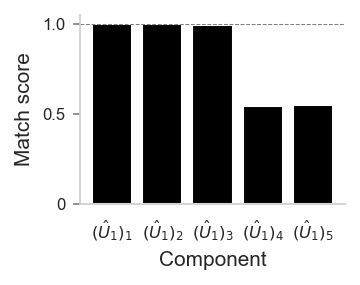

In [242]:
u1_scores, row_inds, col_inds = match_score(gt_concentrations, estimations_concentrations, return_indices=True)
print(u1_scores)
print(col_inds)
print(row_inds)

plt.figure(figsize=(2.5, 2), dpi=150)
plt.axhline(1, color="grey", linestyle="--", linewidth=0.5)
plt.bar(np.arange(5), u1_scores, color="black")
plt.xticks(np.arange(5), [rf"$(\hat U_1)_{idx}$" for idx in np.arange(1, 6)], fontsize=8)
plt.yticks([0, 0.5, 1.0], [0, 0.5, 1.0], fontsize=8)
plt.tick_params(axis="y", labelsize=8, left=True, color="grey")
plt.xlabel("Component", fontsize=10)
plt.ylabel("Match score", fontsize=10)
plt.grid(False)
plt.gca().spines[["top", "right"]].set_visible(False)
plt.tight_layout()
plt.savefig("figures/cmtf_match_score.pdf", dpi=300)
plt.show()

[2 0 1 3 4]
2
0
1
3
4


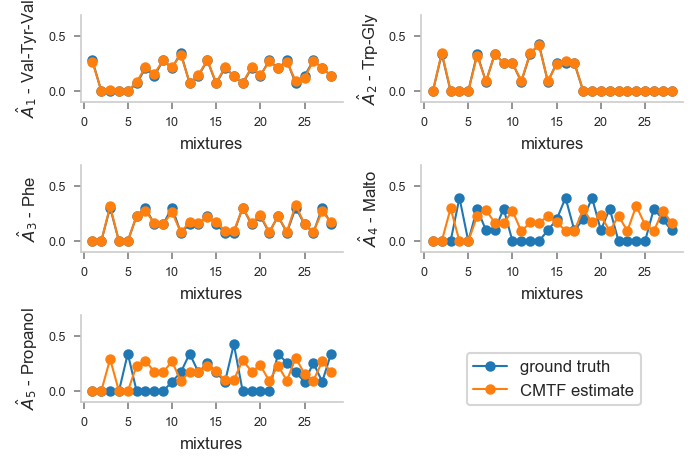

In [243]:
# because the tensor represents concentrations, we take the absolute value
# (non-negative components)
# this is figure 11 of Acar et al. (2014)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(4.54, 3), sharex=False, sharey=False, dpi=150, layout="constrained")
axes = axes.flatten()
print(col_inds)
for idx, ax in enumerate(axes[:5]):
    lines1 = ax.plot(np.arange(1, 29), gt_concentrations[:, idx], marker="o", markersize=4, linewidth=1,
                     label="ground truth")
    print(col_inds[idx])
    y = estimations_concentrations[:, col_inds[idx]]
    lines2 = ax.plot(np.arange(1, 29), y, marker="o", markersize=4, linewidth=1, label="CMTF estimate")
    ax.grid(False)
    ax.tick_params(axis="both", labelsize=6, left=True, bottom=True, color="grey")
    ax.spines[["top", "right"]].set_visible(False)
    ax.set_xlabel("mixtures", fontsize=8)
    ax.set_ylabel(rf"$\hat A_{idx + 1}$ - {concentrations.columns[idx]}", fontsize=8)
    ax.set_ylim(-0.1, 0.7)
axes[-1].axis("off")
handles, labels = ax.get_legend_handles_labels()
# fig.tight_layout()
fig.legend(handles, labels, loc='lower center', fontsize=8, ncol=1, bbox_to_anchor=(0.8, 0.1),
           bbox_transform=fig.transFigure)
plt.savefig("figures/cmtf_concentration_estimates.pdf", dpi=300)
plt.show()

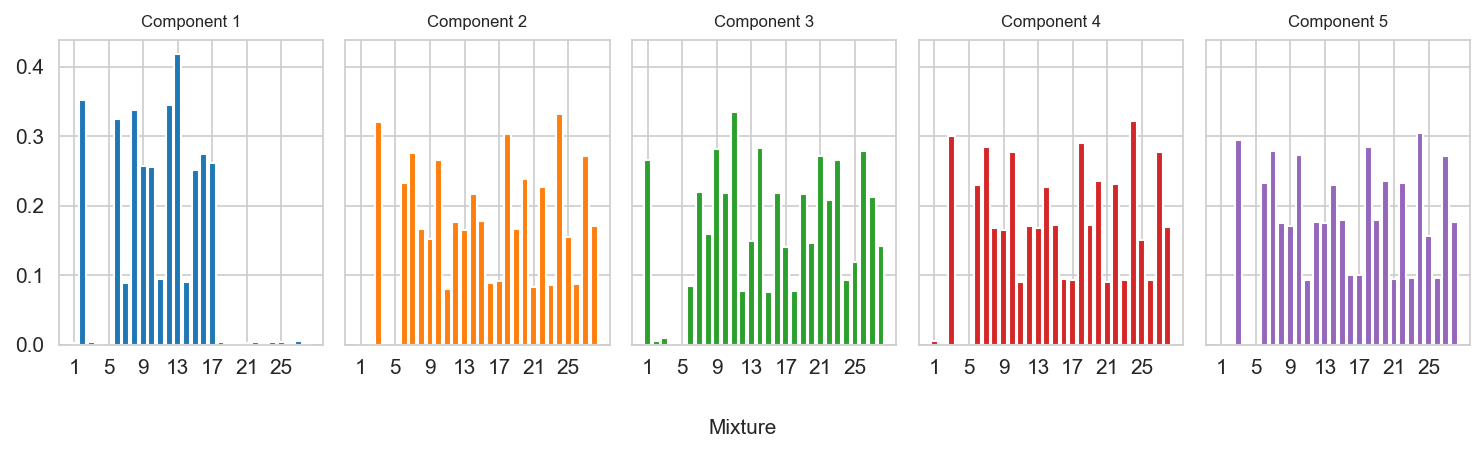

In [244]:
rank = 5
f, ax = plt.subplots(1, rank, figsize=(10, 3), sharex=True, sharey=True, dpi=150)

u1 = out[0]
u1 = tl.cp_normalize((None, [u1])).factors[0]
x_ticks = np.arange(28)

for i in range(rank):
    ax[i].bar(x_ticks, np.abs(u1[:, i]), color=f"C{i}")
    ax[i].set_title(f"Component {i + 1}", fontsize=8)
ax[0].set_xticks(x_ticks[::4], (x_ticks + 1)[::4])
f.supxlabel("Mixture", fontsize=10)
f.tight_layout()
plt.show()